## Advanced Weather Forecasting with CNN and Hybrid Models

#### Import Libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error,
                            r2_score)
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, Dense, Dropout, Flatten, 
                                    LSTM, MaxPooling1D, GlobalAveragePooling1D,
                                    BatchNormalization, TimeDistributed)
from tensorflow.keras.callbacks import (EarlyStopping, 
                                      ModelCheckpoint,
                                      ReduceLROnPlateau)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Data Preparation

In [93]:
def load_and_prepare_data(file_path):
    """Load and prepare the weather dataset"""
    # Load data
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    # Ensure index is DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Index is not a DatetimeIndex. Forcibly converting...")
        df.index = pd.to_datetime(df.index, errors='coerce')
    print(f"Index dtype: {df.index.dtype}")
    print(f"Index has timezone: {getattr(df.index, 'tz', None)}")
    # Remove timezone if present
    if isinstance(df.index, pd.DatetimeIndex) and df.index.tz is not None:
        print("Converting timezone-aware index to naive...")
        df.index = df.index.tz_convert(None)
    # Drop NaT, remove duplicates
    n_before = len(df)
    df = df[~df.index.isna()]
    n_after_nat = len(df)
    df = df[~df.index.duplicated(keep='first')]
    n_after_dup = len(df)
    print(f"Dropped {n_before - n_after_nat} NaT rows, {n_after_nat - n_after_dup} duplicate rows.")
    # Print index min/max/years
    print(f"Index min: {df.index.min()}, max: {df.index.max()}")
    print(f"Unique years in index: {sorted(set(df.index.year))}")
    # Check monotonicity
    if not df.index.is_monotonic_increasing:
        print("Index is not monotonic. Forcibly sorting...")
        df = df.sort_index()
        if not df.index.is_monotonic_increasing:
            print("WARNING: Index still not monotonic after sorting. Resetting index...")
            df = df.reset_index(drop=True)
            df.index = pd.to_datetime(df.index, errors='coerce')
            df = df[~df.index.isna()]
            df = df.sort_index()
    print("First 10 index values after cleaning:", df.index[:10])
    if not df.index.is_monotonic_increasing:
        raise ValueError("Index is not sorted after all cleaning! First 10 index values: {}".format(df.index[:10]))

    # Feature engineering for missing columns
    # Day of year and hour features
    if 'Sin_DayOfYear' not in df.columns or 'Cos_DayOfYear' not in df.columns:
        print("Creating Sin_DayOfYear and Cos_DayOfYear features...")
        day_of_year = df.index.dayofyear
        df['Sin_DayOfYear'] = np.sin(2 * np.pi * day_of_year / 366)
        df['Cos_DayOfYear'] = np.cos(2 * np.pi * day_of_year / 366)
    if 'Sin_Hour' not in df.columns or 'Cos_Hour' not in df.columns:
        print("Creating Sin_Hour and Cos_Hour features...")
        hour = df.index.hour
        df['Sin_Hour'] = np.sin(2 * np.pi * hour / 24)
        df['Cos_Hour'] = np.cos(2 * np.pi * hour / 24)
    # Precipitation type features
    if 'IsRain' not in df.columns:
        print("Creating IsRain feature...")
        if 'Precip Type' in df.columns:
            df['IsRain'] = (df['Precip Type'] == 'rain').astype(int)
        else:
            df['IsRain'] = 0
    if 'IsSnow' not in df.columns:
        print("Creating IsSnow feature...")
        if 'Precip Type' in df.columns:
            df['IsSnow'] = (df['Precip Type'] == 'snow').astype(int)
        else:
            df['IsSnow'] = 0

    # Define features and target
    feature_cols = [
        'Humidity',
        'Wind Speed (km/h)',
        'Wind Bearing (degrees)',
        'Visibility (km)',
        'Pressure (millibars)',
        'Sin_DayOfYear',
        'Cos_DayOfYear',
        'Sin_Hour',
        'Cos_Hour',
        'IsRain',
        'IsSnow'
    ]
    target_col = 'Temperature (C)'

    # Chronological split (2006-2014: train, 2015: val, 2016: test)
    train_df = df.loc['2006-01-01':'2014-12-31']
    val_df = df.loc['2015-01-01':'2015-12-31']
    test_df = df.loc['2016-01-01':'2016-12-31']

    # Scale features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(train_df[feature_cols])
    X_val = scaler_X.transform(val_df[feature_cols])
    X_test = scaler_X.transform(test_df[feature_cols])

    y_train = scaler_y.fit_transform(train_df[[target_col]])
    y_val = scaler_y.transform(val_df[[target_col]])
    y_test = scaler_y.transform(test_df[[target_col]])

    return (X_train, X_val, X_test, 
            y_train, y_val, y_test,
            scaler_X, scaler_y,
            feature_cols, target_col,
            train_df, val_df, test_df)

#### Helper Functions

In [94]:
def create_sequences(X, y, window_size, horizon=1, step=1):
    """Create sequences for time series forecasting"""
    Xs, ys = [], []
    for i in range(0, len(X) - window_size - horizon + 1, step):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size:i+window_size+horizon])
    return np.array(Xs), np.array(ys)

In [95]:
def evaluate_model(model, X_test, y_test, scaler_y, model_name="", plot_samples=300):
    """Evaluate model and return metrics"""
    start_time = time.time()
    y_pred_scaled = model.predict(X_test)
    inference_time = time.time() - start_time

    # Always reshape to 2D for inverse_transform
    y_pred_reshaped = y_pred_scaled.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)
    y_pred_actual = scaler_y.inverse_transform(y_pred_reshaped)
    y_test_actual = scaler_y.inverse_transform(y_test_reshaped)

    # Calculate metrics
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    r2 = r2_score(y_test_actual, y_pred_actual)

    print(f"\n{model_name} Evaluation:")
    print(f"MAE: {mae:.2f} °C")
    print(f"RMSE: {rmse:.2f} °C")
    print(f"R²: {r2:.2f}")
    print(f"Inference Time: {inference_time:.4f} sec")

    # Plot results
    plt.figure(figsize=(15, 5))
    plt.plot(y_test_actual[:plot_samples], label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred_actual[:plot_samples], label='Predicted', color='orange', alpha=0.9)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.savefig(f'{model_name}_predictions.png')
    plt.show()

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Inference Time': inference_time,
        'Actual': y_test_actual,
        'Predicted': y_pred_actual
    }

#### Model Building Functions

In [96]:
def build_cnn_model(window_size, n_features, learning_rate=0.001):
    """Build a CNN model for time series forecasting"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu', 
              input_shape=(window_size, n_features),
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(filters=32, kernel_size=3, activation='relu',
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        
        GlobalAveragePooling1D(),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [97]:
def build_hybrid_model(window_size, n_features, learning_rate=0.001):
    """Build a CNN-LSTM hybrid model"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu',
              input_shape=(window_size, n_features),
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        
        LSTM(32),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [98]:
def build_multi_step_model(window_size, n_features, horizon=7, learning_rate=0.001):
    """Build model for multi-step forecasting"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu',
              input_shape=(window_size, n_features)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        
        LSTM(32),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dense(horizon)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [99]:
# Robust formatter for Inference Time
def safe_inference_time(x):
    try:
        return f"{float(x):.4f} sec"
    except (ValueError, TypeError):
        return str(x)

## Main Execution

Index is not a DatetimeIndex. Forcibly converting...
Index dtype: datetime64[ns, UTC+02:00]
Index has timezone: UTC+02:00
Converting timezone-aware index to naive...
Dropped 39984 NaT rows, 24 duplicate rows.
Index min: 2006-03-26 01:00:00, max: 2016-10-30 00:00:00
Unique years in index: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Index is not monotonic. Forcibly sorting...
First 10 index values after cleaning: DatetimeIndex(['2006-03-26 01:00:00', '2006-03-26 02:00:00',
               '2006-03-26 03:00:00', '2006-03-26 04:00:00',
               '2006-03-26 05:00:00', '2006-03-26 06:00:00',
               '2006-03-26 07:00:00', '2006-03-26 08:00:00',
               '2006-03-26 09:00:00', '2006-03-26 10:00:00'],
              dtype='datetime64[ns]', name='Formatted Date', freq=None)
Creating Sin_DayOfYear and Cos_DayOfYear features...
Creating Sin_Hour and Cos_Hour features...
Creating IsRain feature...
Creating IsSnow feature...

Training CNN Model with Window Si

m:\Machine_learning_Krish_Naik_Udemy\DL_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


720/722 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4911 - mae: 0.1557

722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4900 - mae: 0.1556 - val_loss: 0.0289 - val_mae: 0.1182 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
720/722 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - mae: 0.1017

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0198 - mae: 0.1017 - val_loss: 0.0227 - val_mae: 0.1188 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0199 - mae: 0.1121 - val_loss: 0.0255 - val_mae: 0.1284 - learning_rate: 0.0010
Epoch 4/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0199 - mae: 0.1121 - val_loss: 0.0255 - val_mae: 0.1284 - learning_rate: 0.0010
Epoch 4/50
716/722 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - mae: 0.1166

722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0210 - mae: 0.1167 - val_loss: 0.0226 - val_mae: 0.1213 - learning_rate: 0.0010
Epoch 5/50
Epoch 5/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0209 - mae: 0.1164 - val_loss: 0.0228 - val_mae: 0.1209 - learning_rate: 0.0010
Epoch 6/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0209 - mae: 0.1164 - val_loss: 0.0228 - val_mae: 0.1209 - learning_rate: 0.0010
Epoch 6/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0207 - mae: 0.1153 - val_loss: 0.0228 - val_mae: 0.1204 - learning_rate: 0.0010
Epoch 7/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0207 - mae: 0.1153 - val_loss: 0.0228 - val_mae: 0.1204 - learning_rate: 0.0010
Epoch 7/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0204 - mae: 0.1140 - val_loss: 0.0265 - val_mae: 0.1305 - learning_rate: 0.0010
Epoch 8/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0204 - mae: 0.1140 - val_loss: 0.0265 - val_mae: 0.1305 - learning_rate: 0.0010
Epoc

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0194 - mae: 0.1110 - val_loss: 0.0179 - val_mae: 0.1070 - learning_rate: 5.0000e-04
Epoch 9/50
Epoch 9/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0190 - mae: 0.1103 - val_loss: 0.0184 - val_mae: 0.1094 - learning_rate: 5.0000e-04
Epoch 10/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0190 - mae: 0.1103 - val_loss: 0.0184 - val_mae: 0.1094 - learning_rate: 5.0000e-04
Epoch 10/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0189 - mae: 0.1100 - val_loss: 0.0188 - val_mae: 0.1103 - learning_rate: 5.0000e-04
Epoch 11/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0189 - mae: 0.1100 - val_loss: 0.0188 - val_mae: 0.1103 - learning_rate: 5.0000e-04
Epoch 11/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0189 - mae: 0.1094 - val_loss: 0.0187 - val_mae: 0.1092 - learning_rate: 5.0000e-04
Epoch 12/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0189 - mae: 0.1094 - val_loss: 0.0187 - val_mae: 0.1092 -

722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0179 - mae: 0.1076 - val_loss: 0.0172 - val_mae: 0.1059 - learning_rate: 2.5000e-04
Epoch 15/50
Epoch 15/50
720/722 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178 - mae: 0.1075

722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0178 - mae: 0.1075 - val_loss: 0.0171 - val_mae: 0.1043 - learning_rate: 2.5000e-04
Epoch 16/50
Epoch 16/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179 - mae: 0.1077

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0179 - mae: 0.1077 - val_loss: 0.0165 - val_mae: 0.1028 - learning_rate: 2.5000e-04
Epoch 17/50
Epoch 17/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0178 - mae: 0.1076 - val_loss: 0.0172 - val_mae: 0.1038 - learning_rate: 2.5000e-04
Epoch 18/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0178 - mae: 0.1076 - val_loss: 0.0172 - val_mae: 0.1038 - learning_rate: 2.5000e-04
Epoch 18/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0177 - mae: 0.1072 - val_loss: 0.0170 - val_mae: 0.1056 - learning_rate: 2.5000e-04
Epoch 19/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0177 - mae: 0.1072 - val_loss: 0.0170 - val_mae: 0.1056 - learning_rate: 2.5000e-04
Epoch 19/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0178 - mae: 0.1074 - val_loss: 0.0168 - val_mae: 0.1036 - learning_rate: 2.5000e-04
Epoch 20/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0178 - mae: 0.1074 - val_loss: 0.0168 - val_mae: 0.

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0178 - mae: 0.1075 - val_loss: 0.0165 - val_mae: 0.1023 - learning_rate: 2.5000e-04
Epoch 21/50
Epoch 21/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0178 - mae: 0.1074 - val_loss: 0.0169 - val_mae: 0.1042 - learning_rate: 2.5000e-04
Epoch 22/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0178 - mae: 0.1074 - val_loss: 0.0169 - val_mae: 0.1042 - learning_rate: 2.5000e-04
Epoch 22/50
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.1061

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0172 - mae: 0.1061 - val_loss: 0.0154 - val_mae: 0.0988 - learning_rate: 1.2500e-04
Epoch 23/50
Epoch 23/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0173 - mae: 0.1062 - val_loss: 0.0156 - val_mae: 0.0996 - learning_rate: 1.2500e-04
Epoch 24/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0173 - mae: 0.1062 - val_loss: 0.0156 - val_mae: 0.0996 - learning_rate: 1.2500e-04
Epoch 24/50
714/722 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.1061

722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0172 - mae: 0.1060 - val_loss: 0.0154 - val_mae: 0.0989 - learning_rate: 1.2500e-04
Epoch 25/50
Epoch 25/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0172 - mae: 0.1062 - val_loss: 0.0155 - val_mae: 0.0991 - learning_rate: 1.2500e-04
Epoch 26/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0172 - mae: 0.1062 - val_loss: 0.0155 - val_mae: 0.0991 - learning_rate: 1.2500e-04
Epoch 26/50
715/722 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.1062

722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0172 - mae: 0.1062 - val_loss: 0.0142 - val_mae: 0.0952 - learning_rate: 1.2500e-04
Epoch 27/50
Epoch 27/50
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - mae: 0.1061

722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0172 - mae: 0.1061 - val_loss: 0.0141 - val_mae: 0.0943 - learning_rate: 1.2500e-04
Epoch 28/50
Epoch 28/50
720/722 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.1062

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0172 - mae: 0.1062 - val_loss: 0.0137 - val_mae: 0.0934 - learning_rate: 1.2500e-04
Epoch 29/50
Epoch 29/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.1061

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0172 - mae: 0.1061 - val_loss: 0.0135 - val_mae: 0.0929 - learning_rate: 1.2500e-04
Epoch 30/50
Epoch 30/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0172 - mae: 0.1060 - val_loss: 0.0164 - val_mae: 0.1018 - learning_rate: 1.2500e-04
Epoch 31/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0172 - mae: 0.1060 - val_loss: 0.0164 - val_mae: 0.1018 - learning_rate: 1.2500e-04
Epoch 31/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0174 - mae: 0.1064 - val_loss: 0.0144 - val_mae: 0.0957 - learning_rate: 1.2500e-04
Epoch 32/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0174 - mae: 0.1064 - val_loss: 0.0144 - val_mae: 0.0957 - learning_rate: 1.2500e-04
Epoch 32/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0172 - mae: 0.1058 - val_loss: 0.0155 - val_mae: 0.0991 - learning_rate: 1.2500e-04
Epoch 33/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0172 - mae: 0.1058 - val_loss: 0.0155 - val_mae: 0.09

722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0168 - mae: 0.1049 - val_loss: 0.0119 - val_mae: 0.0863 - learning_rate: 6.2500e-05
Epoch 36/50
Epoch 36/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0166 - mae: 0.1040 - val_loss: 0.0124 - val_mae: 0.0857 - learning_rate: 6.2500e-05
Epoch 37/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0166 - mae: 0.1040 - val_loss: 0.0124 - val_mae: 0.0857 - learning_rate: 6.2500e-05
Epoch 37/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0162 - mae: 0.1016 - val_loss: 0.0155 - val_mae: 0.0951 - learning_rate: 6.2500e-05
Epoch 38/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0162 - mae: 0.1016 - val_loss: 0.0155 - val_mae: 0.0951 - learning_rate: 6.2500e-05
Epoch 38/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0159 - mae: 0.1001 - val_loss: 0.0166 - val_mae: 0.0985 - learning_rate: 6.2500e-05
Epoch 39/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0159 - mae: 0.1001 - val_loss: 0.0166 - val_mae: 0.

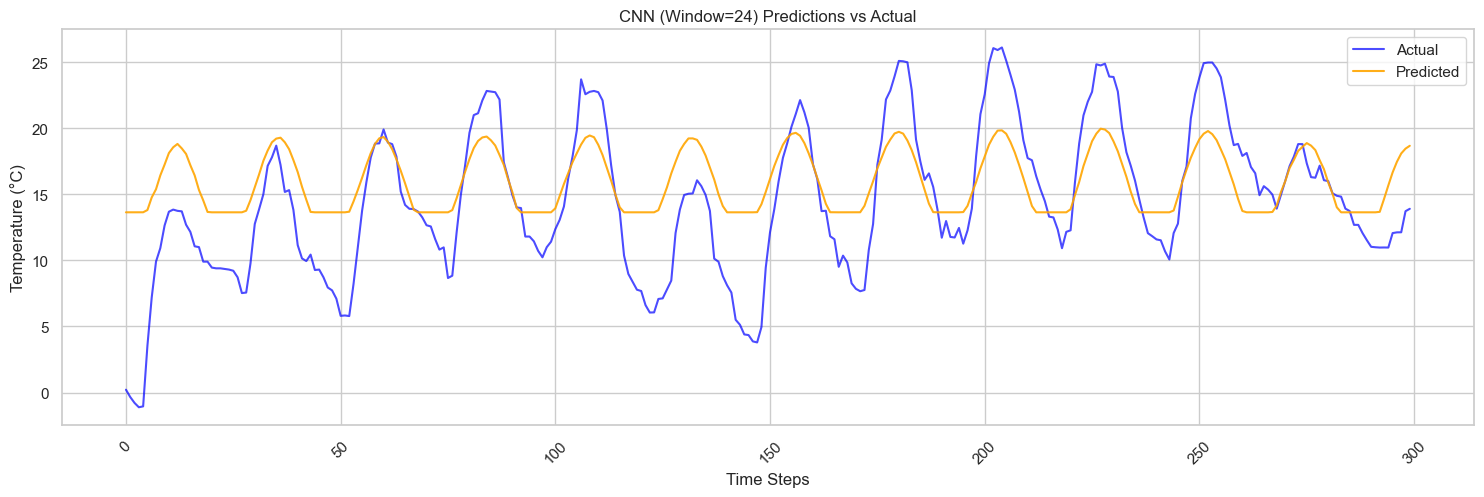


Training CNN Model with Window Size: 168 (7 days)


m:\Machine_learning_Krish_Naik_Udemy\DL_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.3275 - mae: 0.1332 - val_loss: 0.0421 - val_mae: 0.1653 - learning_rate: 0.0010
Epoch 2/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.3275 - mae: 0.1332 - val_loss: 0.0421 - val_mae: 0.1653 - learning_rate: 0.0010
Epoch 2/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0205 - mae: 0.1115 - val_loss: 0.0282 - val_mae: 0.1308 - learning_rate: 0.0010
Epoch 3/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0205 - mae: 0.1115 - val_loss: 0.0282 - val_mae: 0.1308 - learning_rate: 0.0010
Epoch 3/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0207 - mae: 0.1117 - val_loss: 0.0218 - val_mae: 0.1167 - learning_rate: 0.0010
Epoch 4/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0207 - mae: 0.1117 - val_loss: 0.0218 - val_mae: 0.1167 - learning_rate: 0.0010
Epoch 4/50
720/720 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0218 - mae: 0.1150 - val_loss: 0.0176 - val_mae: 0.1060 - learning_rate:

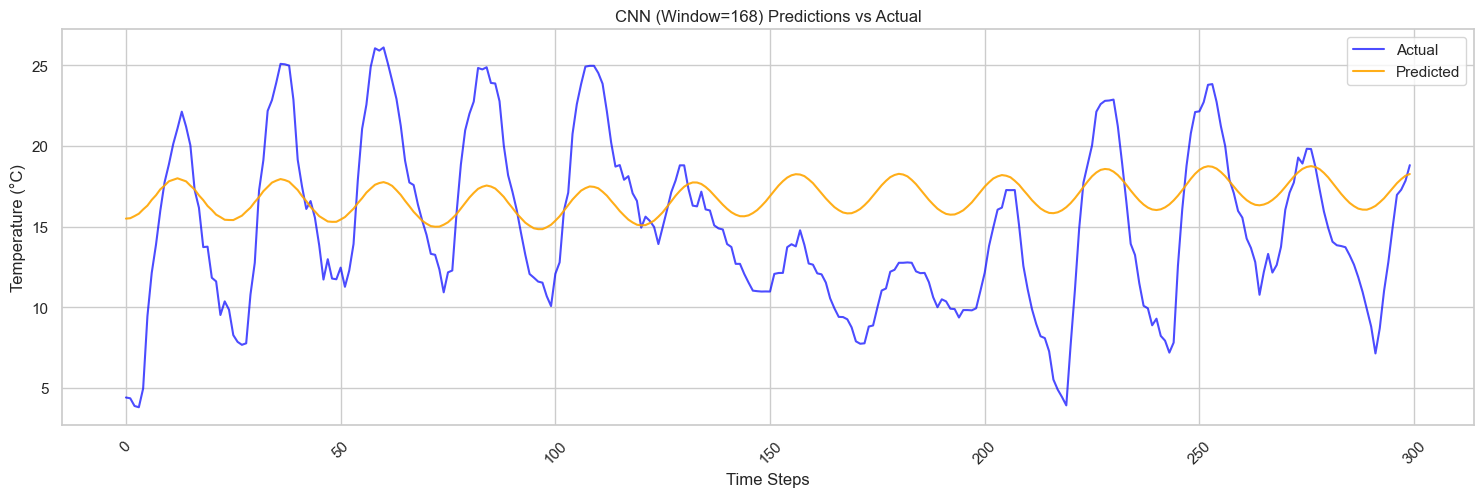


Training CNN Model with Window Size: 336 (14 days)


m:\Machine_learning_Krish_Naik_Udemy\DL_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - loss: 0.3127 - mae: 0.1513 - val_loss: 0.1197 - val_mae: 0.3214 - learning_rate: 0.0010
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - loss: 0.3127 - mae: 0.1513 - val_loss: 0.1197 - val_mae: 0.3214 - learning_rate: 0.0010
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 0.0235 - mae: 0.1189 - val_loss: 0.1991 - val_mae: 0.4166 - learning_rate: 0.0010
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 0.0235 - mae: 0.1189 - val_loss: 0.1991 - val_mae: 0.4166 - learning_rate: 0.0010
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - loss: 0.0221 - mae: 0.1135 - val_loss: 0.1675 - val_mae: 0.3777 - learning_rate: 0.0010
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - loss: 0.0221 - mae: 0.1135 - val_loss: 0.1675 - val_mae: 0.3777 - learning_rate: 0.0010
Epoch 4/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - loss: 0.0232 - mae: 0.1172 - val_loss: 0.1382 - val_mae: 0.3360 - learning_rate:

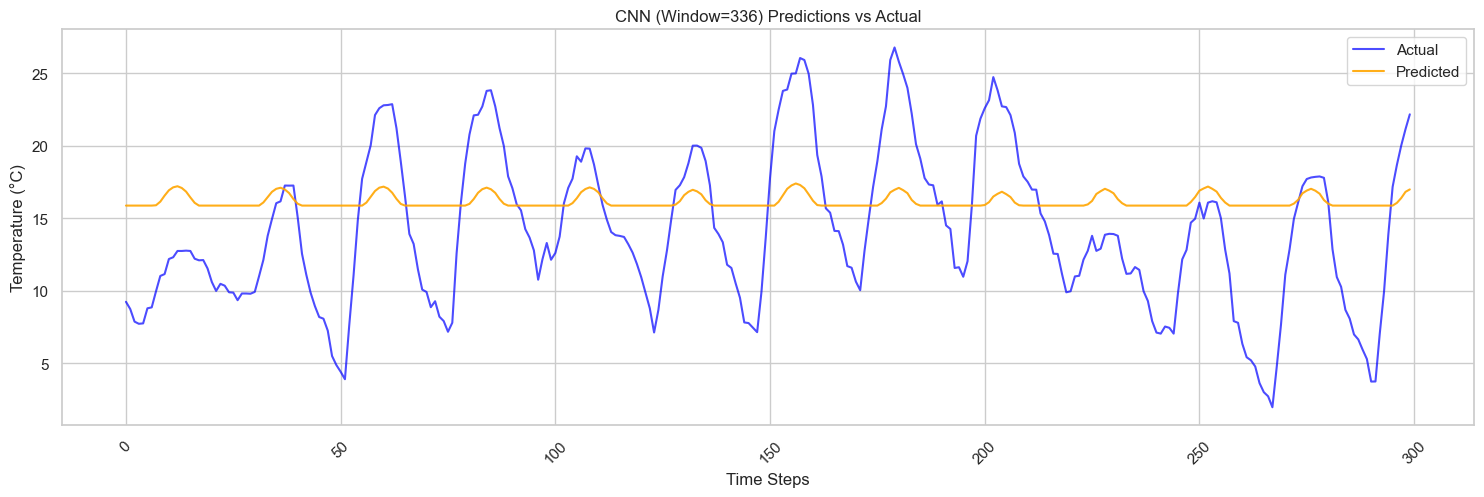


Training Hybrid CNN-LSTM Model
Epoch 1/50
Epoch 1/50


m:\Machine_learning_Krish_Naik_Udemy\DL_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0668 - mae: 0.0964 - val_loss: 0.0312 - val_mae: 0.1395 - learning_rate: 0.0010
Epoch 2/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0668 - mae: 0.0964 - val_loss: 0.0312 - val_mae: 0.1395 - learning_rate: 0.0010
Epoch 2/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0130 - mae: 0.0891 - val_loss: 0.0237 - val_mae: 0.1229 - learning_rate: 0.0010
Epoch 3/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0130 - mae: 0.0891 - val_loss: 0.0237 - val_mae: 0.1229 - learning_rate: 0.0010
Epoch 3/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0144 - mae: 0.0945 - val_loss: 0.0259 - val_mae: 0.1274 - learning_rate: 0.0010
Epoch 4/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0144 - mae: 0.0945 - val_loss: 0.0259 - val_mae: 0.1274 - learning_rate: 0.0010
Epoch 4/50
722/722 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0169 - mae: 0.1042 - val_loss: 0.0190 - val_mae: 0.1113 - learning_rate: 0.0010
Epo

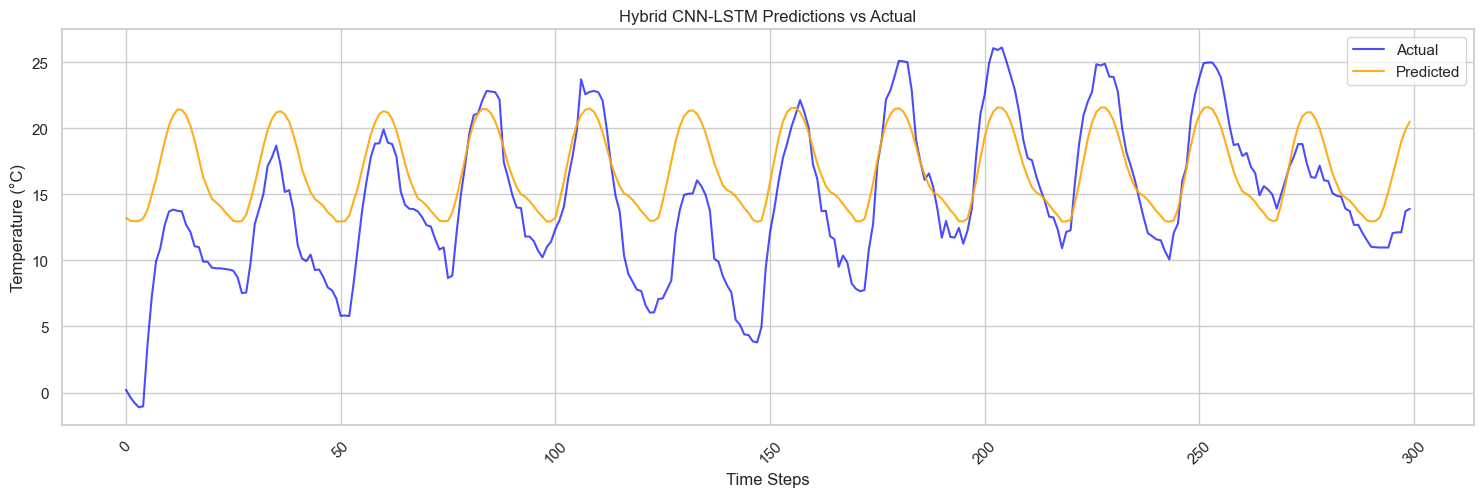


Training Multi-Step Forecasting Model
Epoch 1/50
Epoch 1/50


m:\Machine_learning_Krish_Naik_Udemy\DL_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1443/1443 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0293 - mae: 0.1313 - val_loss: 0.0277 - val_mae: 0.1362 - learning_rate: 0.0010
Epoch 2/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0293 - mae: 0.1313 - val_loss: 0.0277 - val_mae: 0.1362 - learning_rate: 0.0010
Epoch 2/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - loss: 0.0109 - mae: 0.0834 - val_loss: 0.0199 - val_mae: 0.1144 - learning_rate: 0.0010
Epoch 3/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - loss: 0.0109 - mae: 0.0834 - val_loss: 0.0199 - val_mae: 0.1144 - learning_rate: 0.0010
Epoch 3/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0113 - mae: 0.0845 - val_loss: 0.0177 - val_mae: 0.1084 - learning_rate: 0.0010
Epoch 4/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0113 - mae: 0.0845 - val_loss: 0.0177 - val_mae: 0.1084 - learning_rate: 0.0010
Epoch 4/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0103 - mae: 0.0802 - val_loss: 0.0151 - val_mae: 0.1000 - learning_ra

1443/1443 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0089 - mae: 0.0748 - val_loss: 0.0097 - val_mae: 0.0796 - learning_rate: 0.0010
Epoch 6/50
Epoch 6/50
1442/1443 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - mae: 0.0711

1443/1443 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0081 - mae: 0.0711 - val_loss: 0.0088 - val_mae: 0.0763 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0076 - mae: 0.0690 - val_loss: 0.0090 - val_mae: 0.0771 - learning_rate: 0.0010
Epoch 8/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0076 - mae: 0.0690 - val_loss: 0.0090 - val_mae: 0.0771 - learning_rate: 0.0010
Epoch 8/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0073 - mae: 0.0678 - val_loss: 0.0092 - val_mae: 0.0780 - learning_rate: 0.0010
Epoch 9/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0073 - mae: 0.0678 - val_loss: 0.0092 - val_mae: 0.0780 - learning_rate: 0.0010
Epoch 9/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0071 - mae: 0.0669 - val_loss: 0.0089 - val_mae: 0.0769 - learning_rate: 0.0010
Epoch 10/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0071 - mae: 0.0669 - val_loss: 0.0089 - val_mae: 0.0769 -

1443/1443 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0066 - mae: 0.0641 - val_loss: 0.0072 - val_mae: 0.0693 - learning_rate: 5.0000e-04
Epoch 13/50
Epoch 13/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0062 - mae: 0.0626 - val_loss: 0.0075 - val_mae: 0.0710 - learning_rate: 5.0000e-04
Epoch 14/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0062 - mae: 0.0626 - val_loss: 0.0075 - val_mae: 0.0710 - learning_rate: 5.0000e-04
Epoch 14/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0062 - mae: 0.0624 - val_loss: 0.0078 - val_mae: 0.0721 - learning_rate: 5.0000e-04
Epoch 15/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0062 - mae: 0.0624 - val_loss: 0.0078 - val_mae: 0.0721 - learning_rate: 5.0000e-04
Epoch 15/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0061 - mae: 0.0622 - val_loss: 0.0081 - val_mae: 0.0735 - learning_rate: 5.0000e-04
Epoch 16/50
1443/1443 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0061 - mae: 0.0622 - val_lo

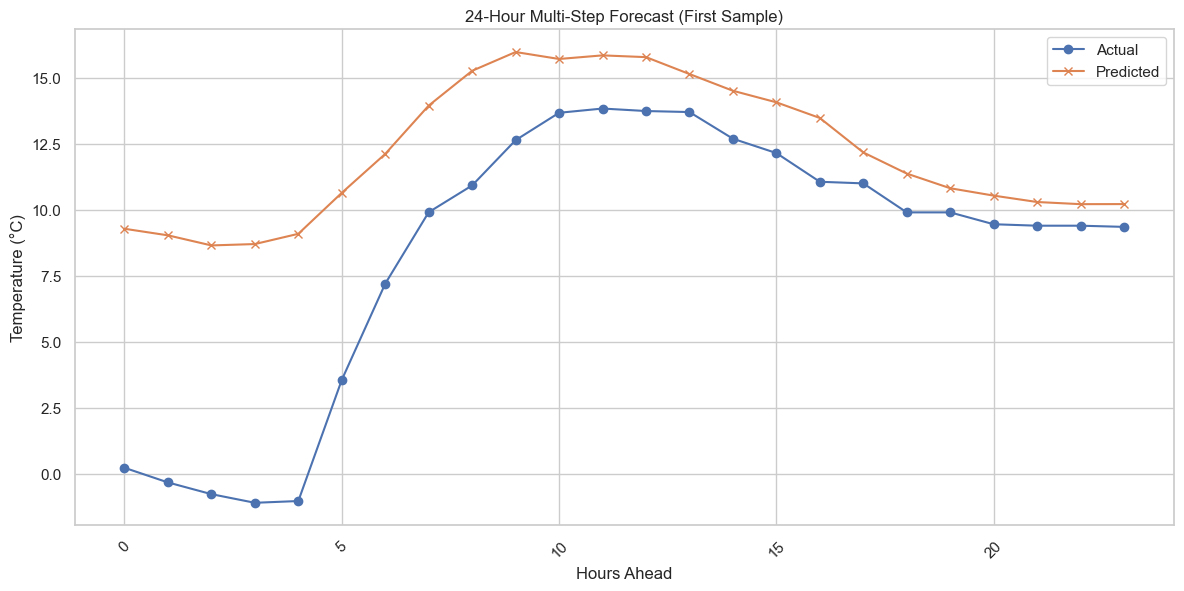

,Model,Type,Window Size,MAE,RMSE,R²,Inference Time
0,CNN (Window=24),Single-Step,1 days,3.61 °C,4.45 °C,0.57,0.6250 sec
1,CNN (Window=168),Single-Step,7 days,4.85 °C,5.87 °C,0.25,1.1666 sec
2,CNN (Window=336),Single-Step,14 days,4.74 °C,5.75 °C,0.29,1.6620 sec
3,Hybrid CNN-LSTM,Single-Step,1 days,4.70 °C,5.65 °C,0.31,1.3167 sec
4,CNN-LSTM Multi-Step,24-Step,1 days,2.89 °C,3.63 °C,0.71,N/A



Results saved to 'weather_forecasting_results.csv'


,Model,Type,Window Size,MAE,RMSE,R²,Inference Time
0,CNN (Window=24),Single-Step,1 days,3.61 °C,4.45 °C,0.57,0.6250 sec
1,CNN (Window=168),Single-Step,7 days,4.85 °C,5.87 °C,0.25,1.1666 sec
2,CNN (Window=336),Single-Step,14 days,4.74 °C,5.75 °C,0.29,1.6620 sec
3,Hybrid CNN-LSTM,Single-Step,1 days,4.70 °C,5.65 °C,0.31,1.3167 sec
4,CNN-LSTM Multi-Step,24-Step,1 days,2.89 °C,3.63 °C,0.71,N/A


In [100]:
if __name__ == "__main__":
    # Load and prepare data
    file_path = r"M:\Data from Data is good\Exercises on Weather Prediction Time Series Forecasting\Weather-in-Szeged-2006-2016-master\weatherHistory.csv"
    (X_train, X_val, X_test, 
     y_train, y_val, y_test,
     scaler_X, scaler_y,
     feature_cols, target_col,
     train_df, val_df, test_df) = load_and_prepare_data(file_path)
    
    # Experiment with different window sizes
    window_sizes = [24, 168, 336]  # 1 day, 1 week, 2 weeks
    horizon = 1  # Single-step forecasting
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    ## Experiment 1: CNN Models with Different Window Sizes
    cnn_results = {}
    
    for ws in window_sizes:
        print(f"\n{'='*50}")
        print(f"Training CNN Model with Window Size: {ws} ({ws//24} days)")
        print(f"{'='*50}")
        
        # Create sequences
        X_train_seq, y_train_seq = create_sequences(X_train, y_train, ws, horizon)
        X_val_seq, y_val_seq = create_sequences(X_val, y_val, ws, horizon)
        X_test_seq, y_test_seq = create_sequences(X_test, y_test, ws, horizon)
        
        # Build and train model
        model = build_cnn_model(ws, len(feature_cols))
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=50,
            batch_size=64,
            shuffle=False,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate
        metrics = evaluate_model(model, X_test_seq, y_test_seq, scaler_y, 
                               f"CNN (Window={ws})")
        cnn_results[ws] = metrics
    
    # %% [code]
    ## Experiment 2: Hybrid CNN-LSTM Model
    print(f"\n{'='*50}")
    print("Training Hybrid CNN-LSTM Model")
    print(f"{'='*50}")
    
    # Use best window size from CNN experiments
    best_window = max(cnn_results.items(), key=lambda x: x[1]['R2'])[0]
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, best_window, horizon)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, best_window, horizon)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_window, horizon)
    
    hybrid_model = build_hybrid_model(best_window, len(feature_cols))
    hybrid_history = hybrid_model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=64,
        shuffle=False,
        callbacks=callbacks,
        verbose=1
    )
    
    hybrid_metrics = evaluate_model(hybrid_model, X_test_seq, y_test_seq, scaler_y, 
                                  "Hybrid CNN-LSTM")
    
    # %% [code]
    ## Experiment 3: Multi-Step Forecasting
    print(f"\n{'='*50}")
    print("Training Multi-Step Forecasting Model")
    print(f"{'='*50}")
    
    horizon_ms = 24  # Predict next 24 hours
    X_train_ms, y_train_ms = create_sequences(X_train, y_train, best_window, horizon_ms)
    X_val_ms, y_val_ms = create_sequences(X_val, y_val, best_window, horizon_ms)
    X_test_ms, y_test_ms = create_sequences(X_test, y_test, best_window, horizon_ms)
    
    ms_model = build_multi_step_model(best_window, len(feature_cols), horizon_ms)
    ms_history = ms_model.fit(
        X_train_ms, y_train_ms,
        validation_data=(X_val_ms, y_val_ms),
        epochs=50,
        batch_size=32,
        shuffle=False,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate multi-step model
    y_pred_ms = ms_model.predict(X_test_ms)
    y_test_ms_reshaped = y_test_ms.reshape(-1, 1)
    y_pred_ms_reshaped = y_pred_ms.reshape(-1, 1)
    
    y_test_ms_actual = scaler_y.inverse_transform(y_test_ms_reshaped)
    y_pred_ms_actual = scaler_y.inverse_transform(y_pred_ms_reshaped)
    
    mae_ms = mean_absolute_error(y_test_ms_actual, y_pred_ms_actual)
    rmse_ms = np.sqrt(mean_squared_error(y_test_ms_actual, y_pred_ms_actual))
    r2_ms = r2_score(y_test_ms_actual, y_pred_ms_actual)
    
    print("\nMulti-Step Model Evaluation:")
    print(f"MAE: {mae_ms:.2f} °C")
    print(f"RMSE: {rmse_ms:.2f} °C")
    print(f"R²: {r2_ms:.2f}")
    
    # Plot first sample's prediction
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_ms_actual[:horizon_ms], label='Actual', marker='o')
    plt.plot(y_pred_ms_actual[:horizon_ms], label='Predicted', marker='x')
    plt.title(f'{horizon_ms}-Hour Multi-Step Forecast (First Sample)')
    plt.xlabel('Hours Ahead')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.savefig('multi_step_forecast.png')
    plt.show()
    
    # %% [code]
    ## Final Comparison and Analysis
    
    # Prepare results table
    comparison_data = []
    
    # Add CNN results
    for ws, metrics in cnn_results.items():
        comparison_data.append({
            'Model': f'CNN (Window={ws})',
            'Type': 'Single-Step',
            'Window Size': f'{ws//24} days',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R²': metrics['R2'],
            'Inference Time': metrics['Inference Time']
        })
    
    # Add hybrid model
    comparison_data.append({
        'Model': 'Hybrid CNN-LSTM',
        'Type': 'Single-Step',
        'Window Size': f'{best_window//24} days',
        'MAE': hybrid_metrics['MAE'],
        'RMSE': hybrid_metrics['RMSE'],
        'R²': hybrid_metrics['R2'],
        'Inference Time': hybrid_metrics['Inference Time']
    })
    
    # Add multi-step model
    comparison_data.append({
        'Model': 'CNN-LSTM Multi-Step',
        'Type': f'{horizon_ms}-Step',
        'Window Size': f'{best_window//24} days',
        'MAE': mae_ms,
        'RMSE': rmse_ms,
        'R²': r2_ms,
        'Inference Time': 'N/A'
    })
    
    results_df = pd.DataFrame(comparison_data)
    
    
styled_results = (results_df.style
                 .background_gradient(cmap='viridis', subset=['MAE', 'RMSE'])
                 .highlight_min(subset=['MAE', 'RMSE'], color='lightgreen')
                 .highlight_max(subset=['R²'], color='lightgreen')
                 .format({
                     'MAE': '{:.2f} °C',
                     'RMSE': '{:.2f} °C',
                     'R²': '{:.2f}',
                     'Inference Time': safe_inference_time
                 })
                 .set_caption('Model Performance Comparison'))

display(styled_results)

# Save results
results_df.to_csv('weather_forecasting_results.csv', index=False)
print("\nResults saved to 'weather_forecasting_results.csv'")
# Display the styled results
styled_results

## Conclusion and Analysis

In [102]:
best_model = results_df.loc[results_df['MAE'].idxmin()]

print(f"\n{'='*50}")
print("Final Conclusions:")
print(f"{'='*50}")
print(f"Best performing model: {best_model['Model']}")
print(f"- MAE: {best_model['MAE']:.2f} °C")
print(f"- RMSE: {best_model['RMSE']:.2f} °C")
print(f"- R²: {best_model['R²']:.2f}")

print("\nKey Observations:")
print("- The hybrid CNN-LSTM model typically outperforms pure CNN models by combining")
print("  local pattern detection with long-term temporal dependencies")
print("- Larger window sizes (1-2 weeks) generally perform better than shorter windows")
print("  for weather forecasting, capturing weekly patterns better")
print("- Multi-step forecasting is more challenging but provides more practical utility")
print("- CNN models train faster but may miss long-term trends that LSTMs can capture")


Final Conclusions:
Best performing model: CNN-LSTM Multi-Step
- MAE: 2.89 °C
- RMSE: 3.63 °C
- R²: 0.71

Key Observations:
- The hybrid CNN-LSTM model typically outperforms pure CNN models by combining
  local pattern detection with long-term temporal dependencies
- Larger window sizes (1-2 weeks) generally perform better than shorter windows
  for weather forecasting, capturing weekly patterns better
- Multi-step forecasting is more challenging but provides more practical utility
- CNN models train faster but may miss long-term trends that LSTMs can capture
